In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,759 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 7.5 MB/s 
     |████████████████████████████████| 209 kB 44.7 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 147 kB 47.4 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 40.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=83ae8b256f294a38602bbf30e5c0353f8d2f7f1003e1dab55b7d5e5bf155d256
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

plt.rc('font', family='NanumBarunGothic') 
from collections import Counter

In [6]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/open/'

In [7]:
data_info_df = pd.read_csv(data_path + 'data_info.csv')
test_df = pd.read_csv(data_path + 'test.csv')
train_df = pd.read_csv(data_path + 'train.csv')

In [8]:
data_info_df

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [9]:
train_df.base_date = pd.to_datetime(train_df.base_date, format='%Y%m%d')
train_df.day_of_week = train_df.base_date.dt.day_of_week
train_df

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,2022-06-23,3,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,2022-07-28,3,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,2021-10-10,6,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,2022-03-11,4,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,2021-10-05,1,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,2021-11-04,3,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,2022-03-31,3,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,2022-06-13,0,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,2021-10-20,2,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


In [10]:
train_df.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)
test_df.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)

In [11]:
train_df.info()
# object 타입의 칼럼이 존재 -> 해당 부분 전처리 생각하기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            int64         
 2   base_hour              int64         
 3   lane_count             int64         
 4   road_rating            int64         
 5   road_name              object        
 6   multi_linked           int64         
 7   connect_code           int64         
 8   maximum_speed_limit    float64       
 9   weight_restricted      float64       
 10  road_type              int64         
 11  start_node_name        object        
 12  start_latitude         float64       
 13  start_longitude        float64       
 14  start_turn_restricted  object        
 15  end_node_name          object        
 16  end_latitude           float64       
 17  end_longitude          float64       
 18  end_turn_restricted   

In [12]:
# 결측치 확인
train_df.loc[train_df.isnull().any(axis = 1)]

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target


In [13]:
train_df.weight_restricted.value_counts()

0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: weight_restricted, dtype: int64

In [14]:
def f(x):
  if x=='없음':
    return 0
  else:
    return 1

In [15]:
train_df.start_turn_restricted = train_df.start_turn_restricted.apply(f)
train_df.end_turn_restricted = train_df.end_turn_restricted.apply(f)

In [16]:
train_df.corr()


,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,target
day_of_week,1.000000,0.005490,0.000745,-0.000206,-0.000250,0.000025,-0.000336,0.000028,0.000655,-0.000178,-0.001285,0.000607,-0.000195,-0.001279,0.000629,0.005911
base_hour,0.005490,1.000000,-0.029194,0.031658,0.005711,-0.002649,-0.036756,-0.003231,-0.007880,-0.021599,-0.011478,-0.012476,-0.021597,-0.011489,-0.012589,-0.159407
lane_count,0.000745,-0.029194,1.000000,-0.095717,-0.026555,-0.029290,0.384002,-0.177224,-0.050715,0.182674,-0.094806,0.292852,0.182330,-0.094732,0.312854,-0.144256
road_rating,-0.000206,0.031658,-0.095717,1.000000,0.024218,-0.054160,-0.327474,-0.118630,-0.125618,-0.204793,0.007401,-0.029050,-0.204843,0.007386,-0.029451,-0.261693
multi_linked,-0.000250,0.005711,-0.026555,0.024218,1.000000,-0.001111,-0.020245,-0.008790,0.042977,-0.014906,0.026895,-0.007202,-0.014907,0.026896,-0.007203,-0.008408
connect_code,0.000025,-0.002649,-0.029290,-0.054160,-0.001111,1.000000,-0.015190,-0.020491,-0.025846,0.036623,-0.045695,-0.016789,0.037163,-0.044853,-0.016791,0.048348
maximum_speed_limit,-0.000336,-0.036756,0.384002,-0.327474,-0.020245,-0.015190,1.000000,0.085080,0.059511,0.253147,-0.033018,0.094124,0.252958,-0.032907,0.104737,0.425715
weight_restricted,0.000028,-0.003231,-0.177224,-0.118630,-0.008790,-0.020491,0.085080,1.000000,0.792803,-0.128291,0.034926,-0.119699,-0.128305,0.034915,-0.119564,0.294092
road_type,0.000655,-0.007880,-0.050715,-0.125618,0.042977,-0.025846,0.059511,0.792803,1.000000,-0.043420,0.033684,-0.103950,-0.043430,0.033664,-0.103781,0.200840
start_latitude,-0.000178,-0.021599,0.182674,-0.204793,-0.014906,0.036623,0.253147,-0.128291,-0.043420,1.000000,0.127042,0.282428,0.999106,0.127005,0.282798,0.036280


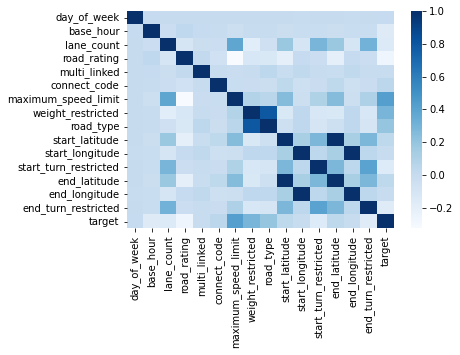

In [17]:
sns.heatmap(train_df.corr(), cmap='Blues')
# lane_count, maximum_speed_limit이 특이해 보임

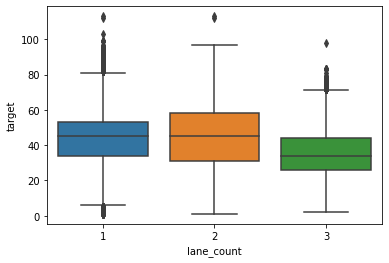

In [18]:
sns.boxplot(data=train_df, x='lane_count', y='target')
# 1, 3의 경우 이상치를 잘라내기 위한 기준 확인 필요
# 2의 경우 이상치가 확실하여 해당 이상치 빼고 학습 예정

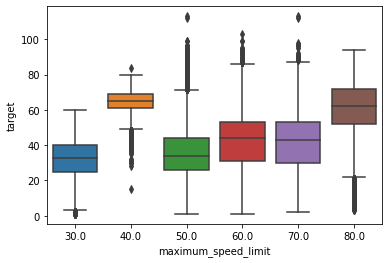

In [19]:
sns.boxplot(data=train_df, x='maximum_speed_limit', y='target')

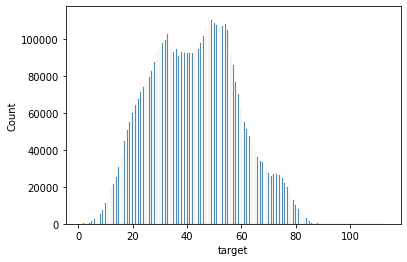

In [20]:
sns.histplot(train_df.target)

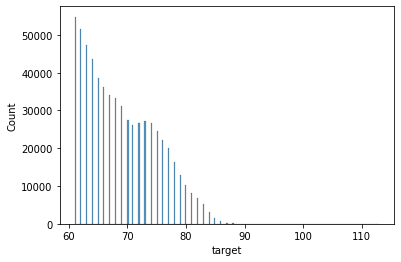

In [21]:
sns.histplot(data = train_df.loc[train_df.target > 60], x = 'target')

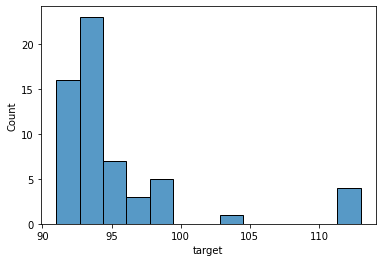

In [22]:
sns.histplot(data = train_df.loc[train_df.target > 90], x = 'target')

In [23]:
train_df.loc[train_df.target > 90]

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
236607,2022-07-13,2,1,1,103,일반국도12호선,0,0,50.0,0.0,0,화순삼거리,33.254612,126.342103,0,남당동,33.257983,126.352935,0,96.0
242903,2021-12-31,4,2,1,103,일반국도12호선,0,0,50.0,0.0,0,화순삼거리,33.254612,126.342103,0,남당동,33.257983,126.352935,0,112.0
245660,2021-10-04,0,1,2,107,-,0,0,50.0,0.0,0,금성동교차로,33.287997,126.739326,0,뒷못동교차로,33.289003,126.744291,0,93.0
292163,2022-07-29,4,2,1,106,지방도1118호선,0,0,50.0,0.0,0,제4교래교,33.430742,126.674333,0,제주삼다수,33.424343,126.675832,0,94.0
532891,2022-07-27,2,1,1,106,지방도1118호선,0,0,50.0,0.0,0,제4교래교,33.430742,126.674333,0,제주삼다수,33.424343,126.675832,0,92.0
540989,2021-10-04,0,2,1,107,-,0,0,50.0,0.0,0,진은교차로,33.284189,126.723306,0,농협하나로마트,33.283593,126.720591,0,94.0
568840,2021-10-04,0,2,2,107,-,0,0,80.0,43200.0,3,하나로교,33.284552,126.724958,0,하나로교,33.284439,126.724447,0,94.0
786997,2022-07-05,1,3,1,106,지방도1118호선,0,0,60.0,0.0,0,제주삼다수,33.424343,126.675832,0,육성목장,33.421793,126.676661,0,92.0
818357,2021-10-03,6,1,1,103,일반국도11호선,0,0,60.0,43200.0,3,성판교,33.392035,126.616635,0,성판교,33.392280,126.616521,0,93.0
835012,2022-07-26,1,3,2,103,일반국도12호선,0,0,70.0,0.0,0,덕수사거리,33.250611,126.303780,0,한전아파트,33.250640,126.308215,0,91.0


In [24]:
(train_df.target - train_df.maximum_speed_limit).mean()

-18.46485069717054

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


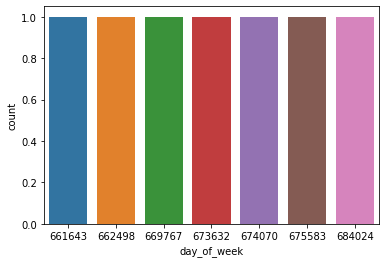

In [25]:
sns.countplot(train_df.day_of_week.value_counts())

In [26]:
day_of_week = ['월', '화', '수', '목', '금', '토', '일']

In [27]:
plt.rc('font', family='NanumBarunGothic') 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_

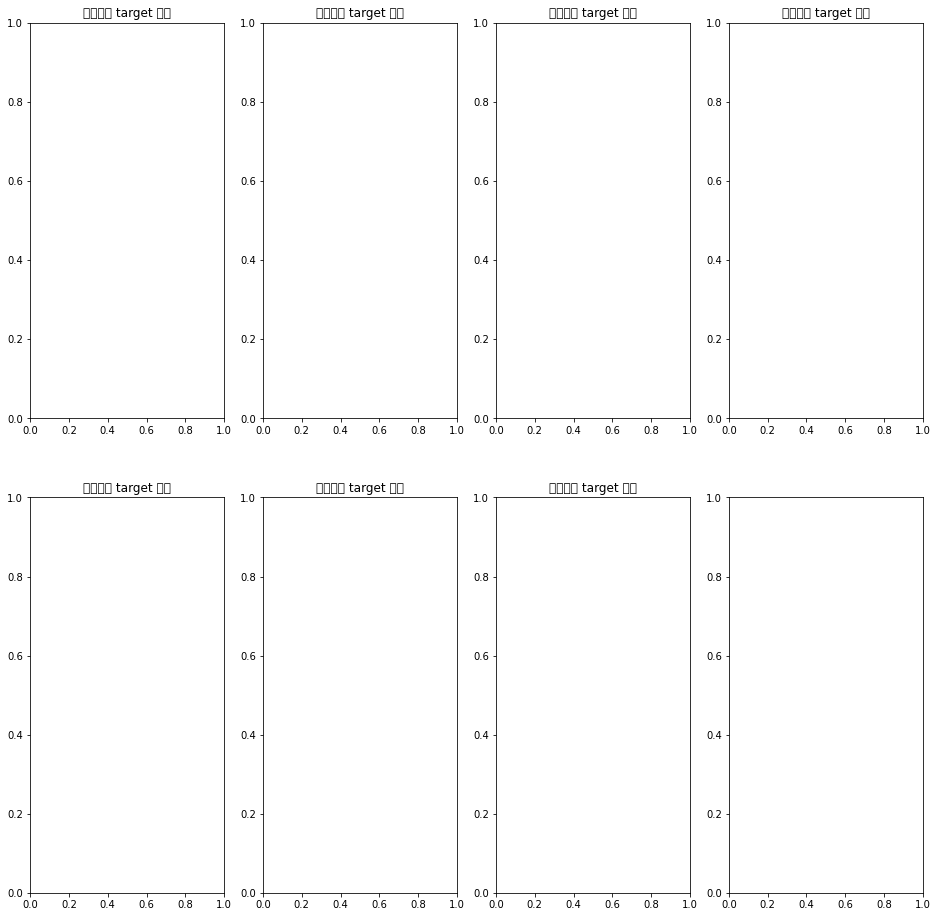

In [28]:
# 평균적으로 목요일이 가장 빠른 속도로 다님
f, ax = plt.subplots(2, 4, figsize=(16, 16))

for day in range(len(day_of_week)):
    sns.histplot(data = train_df.loc[(train_df.day_of_week==day_of_week[day])&(train_df.target>60)], x = 'target', ax=ax[day//4][day%4]);
    ax[day//4][day%4].set_title(f'{day_of_week[day]}요일의 target 분포');
f.show();

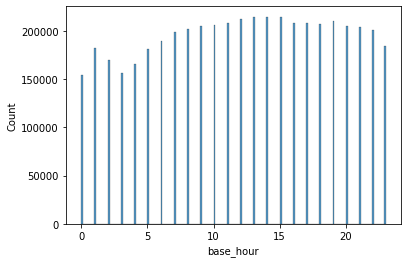

In [29]:
sns.histplot(train_df.base_hour)

In [30]:
len(train_df.start_node_name.unique())

487

In [31]:
len(train_df.road_name.unique())

61

In [32]:
train_df.base_date.min(), train_df.base_date.max()

(Timestamp('2021-09-01 00:00:00'), Timestamp('2022-07-31 00:00:00'))

In [33]:
cctv = pd.read_csv(data_path + '전국무인교통단속카메라표준데이터.csv', encoding='cp949')
cctv

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,...,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명
0,6,경상북도,상주시,일반국도,25번,영남제일로,1,NaN,경상북도 상주시 내서면 낙서리 352-2,36.398710,...,60,NaN,NaN,NaN,NaN,상주경찰서,054-537-0353,2022-06-15,5110000,경상북도 상주시
1,11,전라남도,곡성군,군도,840,창정리,3,NaN,전라남도 곡성군 입면 창정리 165-1,35.305534,...,30,1.0,0.3,2,2020.0,전남지방경찰청,061-362-7000,2022-06-13,4860000,전라남도 곡성군
2,12,전라남도,곡성군,군도,840,읍내리,3,NaN,전라남도 곡성군 곡성읍 읍내리 710-2,35.283373,...,30,1.0,0.3,2,2020.0,전남지방경찰청,061-362-7000,2022-06-13,4860000,전라남도 곡성군
3,13,전라남도,곡성군,군도,840,석곡리,3,NaN,전라남도 곡성군 석곡면 석곡리 8,35.135106,...,30,1.0,0.3,2,2020.0,전남지방경찰청,061-362-7000,2022-06-13,4860000,전라남도 곡성군
4,14,전라남도,곡성군,군도,840,죽림리,3,NaN,전라남도 곡성군 옥과면 죽림리 120-2,35.276399,...,30,1.0,0.3,2,2020.0,전남지방경찰청,061-362-7000,2022-06-13,4860000,전라남도 곡성군
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32676,G1621,경기도,여주시,지방도,333번,여주남로,3,NaN,경기도 여주시 가남읍 본두리 188-7,37.244933,...,50,NaN,NaN,NaN,2018.0,경기남부경찰청,031-888-3952,2022-06-02,5700000,경기도 여주시
32677,G1622,경기도,여주시,지방도,333번,여주남로,3,NaN,경기도 여주시 가남읍 심석리 327-8,37.206880,...,70,NaN,NaN,NaN,2018.0,경기남부경찰청,031-888-3952,2022-06-02,5700000,경기도 여주시
32678,G1624,경기도,여주시,일반국도,3번,경충대로,3,NaN,경기도 여주시 가남읍 은봉리 153,37.180831,...,60,NaN,NaN,NaN,2018.0,경기남부경찰청,031-888-3952,2022-06-02,5700000,경기도 여주시
32679,G1625,경기도,여주시,지방도,333번,설가로,3,NaN,경기도 여주시 가남읍 태평리 504-11,37.199349,...,60,NaN,NaN,NaN,2018.0,경기남부경찰청,031-888-3952,2022-06-02,5700000,경기도 여주시


In [34]:
cctv = cctv.drop(columns=['무인교통단속카메라관리번호']).loc[cctv['시도명']=='제주특별자치도']
cctv

,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,...,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명
8467,제주특별자치도,서귀포시,지방도,1118번,남조로,01,NaN,제주특별자치도 서귀포시 남원읍 의귀리 963-1,33.300907,126.719507,...,60,NaN,NaN,NaN,2021.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
8468,제주특별자치도,서귀포시,지방도,1132번,일주서로,01,NaN,제주특별자치도 서귀포시 대정읍 일과리 1110-5,33.239707,126.233588,...,70,NaN,NaN,NaN,2021.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
8469,제주특별자치도,서귀포시,지방도,1132번,일주서로,01,NaN,제주특별자치도 서귀포시 안덕면 사계리 755-7,33.250412,126.303975,...,30,NaN,NaN,NaN,2021.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
8470,제주특별자치도,제주시,지방도,1131번,516로,02,NaN,제주특별자치도 제주시 아라일동 370-10,33.447728,126.555973,...,50,1.0,2.6,NaN,2021.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
8471,제주특별자치도,제주시,지방도,1139번,산록서로,02,NaN,제주특별자치도 제주시 애월읍 어음리 산 3-2,33.388584,126.376083,...,60,1.0,11.6,NaN,2022.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8926,제주특별자치도,서귀포시,지방도,1136번,중산간동로,01,제주특별자치도 서귀포시 중산간동로 7918,제주특별자치도 서귀포시 동홍동 1091-1,33.265751,126.570421,...,50,NaN,NaN,01,2013.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
8927,제주특별자치도,서귀포시,지방도,1116번,한창로,02,제주특별자치도 서귀포시 안덕면 한창로 365,제주특별자치도 서귀포시 안덕면 상창리 1998,33.288991,126.351411,...,70,NaN,NaN,NaN,2014.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
8928,제주특별자치도,서귀포시,지방도,1116번,한창로,01,제주특별자치도 서귀포시 안덕면 한창로 368,제주특별자치도 서귀포시 안덕면 상창리 1979,33.292441,126.352361,...,70,NaN,NaN,NaN,2014.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청
8929,제주특별자치도,제주시,지방도,1132번,일주서로,01,NaN,제주특별자치도 제주시 한경면 고산리 3149-2,33.298081,126.184501,...,70,NaN,NaN,NaN,2013.0,제주특별자치도경찰청,064-798-3052,2022-06-16,1333203,경찰청 제주특별자치도경찰청


In [35]:
cctv.columns

Index(['시도명', '시군구명', '도로종류', '도로노선번호', '도로노선명', '도로노선방향', '소재지도로명주소',
       '소재지지번주소', '위도', '경도', '설치장소', '단속구분', '제한속도', '단속구간위치구분', '과속단속구간길이',
       '보호구역구분', '설치연도', '관리기관명', '관리기관전화번호', '데이터기준일자', '제공기관코드', '제공기관명'],
      dtype='object')

In [36]:
cctv = cctv[['시군구명', '위도', '경도', '도로노선명', '도로노선방향', '보호구역구분', '설치연도']]

In [37]:
cctv

,시군구명,위도,경도,도로노선명,도로노선방향,보호구역구분,설치연도
8467,서귀포시,33.300907,126.719507,남조로,01,NaN,2021.0
8468,서귀포시,33.239707,126.233588,일주서로,01,NaN,2021.0
8469,서귀포시,33.250412,126.303975,일주서로,01,NaN,2021.0
8470,제주시,33.447728,126.555973,516로,02,NaN,2021.0
8471,제주시,33.388584,126.376083,산록서로,02,NaN,2022.0
...,...,...,...,...,...,...,...
8926,서귀포시,33.265751,126.570421,중산간동로,01,01,2013.0
8927,서귀포시,33.288991,126.351411,한창로,02,NaN,2014.0
8928,서귀포시,33.292441,126.352361,한창로,01,NaN,2014.0
8929,제주시,33.298081,126.184501,일주서로,01,NaN,2013.0


In [38]:
cctv.loc[cctv.isnull().any(axis=1)]

,시군구명,위도,경도,도로노선명,도로노선방향,보호구역구분,설치연도
8467,서귀포시,33.300907,126.719507,남조로,01,NaN,2021.0
8468,서귀포시,33.239707,126.233588,일주서로,01,NaN,2021.0
8469,서귀포시,33.250412,126.303975,일주서로,01,NaN,2021.0
8470,제주시,33.447728,126.555973,516로,02,NaN,2021.0
8471,제주시,33.388584,126.376083,산록서로,02,NaN,2022.0
...,...,...,...,...,...,...,...
8923,제주시,33.495281,126.585021,번영로,01,NaN,2013.0
8927,서귀포시,33.288991,126.351411,한창로,02,NaN,2014.0
8928,서귀포시,33.292441,126.352361,한창로,01,NaN,2014.0
8929,제주시,33.298081,126.184501,일주서로,01,NaN,2013.0


In [39]:
cctv.isnull().sum()

시군구명        0
위도          0
경도          0
도로노선명       0
도로노선방향      0
보호구역구분    211
설치연도        0
dtype: int64

In [40]:
cctv.loc[~(cctv['보호구역구분'].isnull())]

,시군구명,위도,경도,도로노선명,도로노선방향,보호구역구분,설치연도
8487,서귀포시,33.236750,126.509345,이어도로,02,02,2022.0
8493,제주시,33.493381,126.538753,남광로,01,02,2021.0
8494,제주시,33.487976,126.530991,도남로,02,02,2021.0
8495,제주시,33.509282,126.521276,남성로,01,02,2021.0
8497,제주시,33.477828,126.567378,아봉로,01,02,2021.0
8498,제주시,33.514346,126.575982,화삼로,01,02,2021.0
8504,서귀포시,33.259814,126.559294,중앙로,02,02,2021.0
8505,서귀포시,33.259796,126.559304,중앙로,02,02,2021.0
8509,제주시,33.537488,126.672129,일주동로,01,02,2021.0
8510,서귀포시,33.299481,126.765561,일주동로,01,02,2021.0


In [41]:
cctv

,시군구명,위도,경도,도로노선명,도로노선방향,보호구역구분,설치연도
8467,서귀포시,33.300907,126.719507,남조로,01,NaN,2021.0
8468,서귀포시,33.239707,126.233588,일주서로,01,NaN,2021.0
8469,서귀포시,33.250412,126.303975,일주서로,01,NaN,2021.0
8470,제주시,33.447728,126.555973,516로,02,NaN,2021.0
8471,제주시,33.388584,126.376083,산록서로,02,NaN,2022.0
...,...,...,...,...,...,...,...
8926,서귀포시,33.265751,126.570421,중산간동로,01,01,2013.0
8927,서귀포시,33.288991,126.351411,한창로,02,NaN,2014.0
8928,서귀포시,33.292441,126.352361,한창로,01,NaN,2014.0
8929,제주시,33.298081,126.184501,일주서로,01,NaN,2013.0


In [42]:
child = pd.read_csv(data_path + '제주특별자치도_어린이보호구역내_어린이승하차구역_20201231.csv')
child

,관리번호,시도명,시군구명,도로명,보차분리여부,어린이 승하차 구역 폭,시작점위도,시작점경도,종료점위도,종료점경도,관리기관명,관리기관전화번호,데이터기준일자
0,1,제주특별자치도,제주시,구남동2길,분리,2.55,33.487724,126.532675,33.487878,126.532840,제주시,064-120,2020-12-31
1,2,제주특별자치도,제주시,도남로,분리,2.17,33.487840,126.531446,33.487597,126.531763,제주시,064-120,2020-12-31
2,3,제주특별자치도,제주시,해안마을길,분리,3.31,33.456682,126.454913,33.456610,126.454919,제주시,064-120,2020-12-31
3,4,제주특별자치도,제주시,연화로,분리,2.53,33.478569,126.487175,33.478300,126.487198,제주시,064-120,2020-12-31
4,5,제주특별자치도,제주시,연화로,분리,2.62,33.478152,126.487169,33.478268,126.487199,제주시,064-120,2020-12-31
5,6,제주특별자치도,제주시,연화로,분리,2.67,33.477724,126.487162,33.477924,126.487194,제주시,064-120,2020-12-31
6,7,제주특별자치도,제주시,연화로,분리,2.51,33.477524,126.487159,33.477693,126.487187,제주시,064-120,2020-12-31
7,8,제주특별자치도,제주시,화삼북로2길,분리,2.88,33.514573,126.576346,33.514802,126.576314,제주시,064-120,2020-12-31
8,9,제주특별자치도,제주시,신성로6길,분리,1.89,33.493445,126.525079,33.493203,126.524950,제주시,064-120,2020-12-31
9,10,제주특별자치도,제주시,성신로,분리,2.45,33.491725,126.485054,33.491572,126.485169,제주시,064-120,2020-12-31


In [43]:
child.columns

Index(['관리번호', '시도명', '시군구명', '도로명', '보차분리여부', '어린이 승하차 구역 폭', '시작점위도',
       '시작점경도', '종료점위도', '종료점경도', '관리기관명', '관리기관전화번호', '데이터기준일자'],
      dtype='object')

In [49]:
child = child[['도로명', '시작점위도', '시작점경도', '종료점위도', '종료점경도']]

In [75]:
child_start = child[['시작점위도', '시작점경도']]
child_end = child[['종료점위도', '종료점경도']]

In [45]:
tour = pd.read_csv(data_path + '제주관광공사_제주관광정보시스템(VISIT JEJU)_콘텐츠_20220322.csv', encoding='cp949')
tour

,콘텐츠ID,콘텐츠분류,제목,언어,타이틀SEO,연관콘텐츠,지번주소,도로명주소,위도,경도,...,번체공개여부,말레이어공개여부,번체모바일사용여부,말어모바일사용여부,번체승인일시,말레이어승인일시,번체번역요청일시,말레이어번역요청일시,번체SEO자동여부,말레이어SEO자동여부
0,CNTS_000000000021903,숙박,해피펜션,국문,해피펜션,NaN,제주특별자치도 제주시 외도2동 317-1,제주특별자치도 제주시 월대1길 4,33.494110,126.433780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CONT_000000000501391,음식점,탐라 뚝배기,국문,탐라 뚝배기,NaN,제주특별자치도 서귀포시 표선면 표선리 879,제주특별자치도 서귀포시 표선면 표선백사로 127,33.326770,126.836690,...,y,NaN,y,NaN,2019-09-11,NaN,2019-09-11,NaN,y,NaN
2,CONT_000000000501399,음식점,토담골,국문,토담골,NaN,제주특별자치도 제주시 아라이동 2425,제주특별자치도 제주시 간월동로 5,33.485904,126.543496,...,y,NaN,y,NaN,2019-09-09,NaN,2019-09-09,NaN,y,NaN
3,CNTS_000000000018301,음식점,우유부단,국문,우유부단,NaN,제주특별자치도 제주시 한림읍 금악리 142-2,제주특별자치도 제주시 한림읍 금악동길 38,33.347640,126.328260,...,n,NaN,y,NaN,NaN,NaN,2019-02-25,NaN,n,NaN
4,CNTS_000000000020277,관광지,공천포,국문,공천포,NaN,제주특별자치도 서귀포시 남원읍 신례리,제주특별자치도 서귀포시 남원읍 신례리,33.267690,126.645996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5775,CNTS_200000000013110,음식점,카페아오오,국문,카페아오오,NaN,제주특별자치도 서귀포시 성산읍 신산리 420,제주특별자치도 서귀포시 성산읍 환해장성로 75,33.379136,126.879975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,n
5776,CNTS_200000000013120,음식점,샤오츠,국문,샤오츠,NaN,제주특별자치도 서귀포시 성산읍 성산리 392,제주특별자치도 서귀포시 성산읍 성산등용로17번길 55,33.460013,126.929950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,n
5777,CNTS_200000000013109,음식점,옵써빵집,국문,옵써빵집,NaN,제주특별자치도 서귀포시 표선면 표선리 631-4,제주특별자치도 서귀포시 표선면 표선동서로 240,33.325176,126.832586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,n
5778,CNTS_200000000013113,음식점,바램목장&카페,국문,바램목장&카페,NaN,제주특별자치도 서귀포시 안덕면 동광리 259-3,제주특별자치도 서귀포시 안덕면 신화역사로 611,33.311549,126.352635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,n


In [46]:
tour.columns

Index(['콘텐츠ID', '콘텐츠분류', '제목', '언어', '타이틀SEO', '연관콘텐츠', '지번주소', '도로명주소', '위도',
       '경도', '탐나오연동여부', '평점', '소셜네트워크URL', '조회수', '외부검색어', '좋아요수', '리뷰수',
       '북마크수', '일정등록수', '다녀왔어요수', 'PC사용여부', '모바일사용여부', '공개여부', '작성상태', '사용여부',
       '작성상태_1', '영문PC사용여부', '중문PC사용여부', '일문PC사용여부', '영문작성상태', '중문작성상태',
       '일문작성상태', '영문공개여부', '중문공개여부', '일문공개여부', '영문모바일사용여부', '중문모바일사용여부',
       '일문모바일사용여부', '영문승인일시', '중문승인일시', '일문승인일시', '등록자', '등록일시', '수정자', '수정일시',
       'SNS공유수', '인기점수', '등록일시_1', '우편번호', '템플릿여부', '번역요청일시', '영문번역요청일시',
       '중문번역요청일시', '일문번역요청일시', '페이지SEO자동여부', '영문페이지SEO자동여부', '중문페이지SEO자동여부',
       '일문페이지SEO자동여부', '사진공유수', '번체PC사용여부', '말레이어PC사용여부', '번체작성상태', '말레이어작성상태',
       '번체공개여부', '말레이어공개여부', '번체모바일사용여부', '말어모바일사용여부', '번체승인일시', '말레이어승인일시',
       '번체번역요청일시', '말레이어번역요청일시', '번체SEO자동여부', '말레이어SEO자동여부'],
      dtype='object')

In [52]:
#tour = tour[['위도', '경도']]
tour.loc[tour.isnull().any(axis=1)]

,위도,경도
24,NaN,NaN
60,NaN,NaN
61,NaN,NaN
118,NaN,NaN
128,NaN,NaN
...,...,...
5639,NaN,NaN
5663,NaN,NaN
5681,NaN,NaN
5686,NaN,NaN


In [53]:
tour.isnull().count()

위도    5780
경도    5780
dtype: int64

In [57]:
tour = tour.dropna()

In [60]:
parking = pd.read_csv(data_path + '전국주차장정보표준데이터.csv', encoding='cp949')

In [61]:
parking

,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,월정기권요금,결제방법,특기사항,관리기관명,전화번호,위도,경도,데이터기준일자,제공기관코드,제공기관명
0,184-1-000038,산성동제2노상,공영,노상,대전광역시 중구 대둔산로466번길 17,대전광역시 중구 산성동 145-40,14,4,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,대전광역시 중구청 교통과,042-606-6865,36.310891,127.389371,2022-09-16,3650000,대전광역시 중구
1,184-1-000039,산성동제3노상,공영,노상,대전광역시 중구 보문산로 31,대전광역시 중구 산성동 78-5,43,4,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,대전광역시 중구청 교통과,042-606-6865,36.306733,127.384820,2022-09-16,3650000,대전광역시 중구
2,184-1-000040,산성동제4노상,공영,노상,대전광역시 중구 대둔산로480번길 41,대전광역시 중구 산성동 136-95,19,4,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,대전광역시 중구청 교통과,042-606-6865,36.312393,127.391197,2022-09-16,3650000,대전광역시 중구
3,184-1-000041,산성동제5노상,공영,노상,대전광역시 중구 유등천동로 292번길 89-14,대전광역시 중구 산성동 36-1,84,4,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,대전광역시 중구청 교통과,042-606-6865,36.308676,127.390817,2022-09-16,3650000,대전광역시 중구
4,184-1-000042,산성동제6노상,공영,노상,대전광역시 중구 산성로 32,대전광역시 중구 산성동 321,30,4,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,대전광역시 중구청 교통과,042-606-6865,36.306369,127.392383,2022-09-16,3650000,대전광역시 중구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15005,260-2-000032,대화체육관 옆 주차장,공영,노외,강원도 평창군 대화면 대화1길 28-5,강원도 평창군 대화면 대화리 971-3,22,1,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,강원도 평창군청,033-330-2285,37.498525,128.456877,2022-09-27,4280000,강원도 평창군
15006,260-2-000033,대화중고등학교 앞 주차장,공영,노외,강원도 평창군 대화면 대화중앙로 32-8,강원도 평창군 대화면 대화리 857-1,26,1,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,강원도 평창군청,033-330-2285,37.493297,128.459982,2022-09-27,4280000,강원도 평창군
15007,260-2-000034,법장사입구 주차장,공영,노외,강원도 평창군 대화면 고대동길 168,강원도 평창군 대화면 대화리 1758-15,10,1,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,강원도 평창군청,033-330-2285,37.521537,128.451737,2022-09-27,4280000,강원도 평창군
15008,260-2-000035,면사무소앞 주차장(신설),공영,노외,강원도 평창군 대화면 남산2길 20,강원도 평창군 대화면 대화리 1171,30,1,미시행,평일+토요일+공휴일,...,NaN,NaN,NaN,강원도 평창군청,033-330-2285,37.501060,128.457081,2022-09-27,4280000,강원도 평창군


In [67]:
parking = parking.loc[parking['제공기관명'].str.contains('제주')]

In [68]:
parking.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
       '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
       '관리기관명', '전화번호', '위도', '경도', '데이터기준일자', '제공기관코드', '제공기관명'],
      dtype='object')

In [72]:
parking[['위도', '경도']].loc[parking[['위도', '경도']].isnull().any(axis=1)]

,위도,경도
12745,NaN,NaN
12801,33.493556,NaN
12848,33.473555,NaN
12960,33.486694,NaN
12966,33.503305,NaN
12970,33.555303,NaN
12971,NaN,126.300444
12977,NaN,NaN
12978,NaN,NaN


In [73]:
parking = parking[['위도', '경도']].dropna()
parking

,위도,경도
8326,33.205986,126.288942
8327,33.278790,126.721369
8328,33.466746,126.904560
8329,33.277405,126.703351
8330,33.325078,126.833875
...,...,...
12969,33.494224,126.460708
12973,33.364599,126.200386
12974,33.548269,126.650334
12975,33.463215,126.334189


In [76]:
def cal_dist(x1, y1, x2, y2, a, b):
    
    area = abs((x1 - a) * (y2 - b) - (y1 - b) * (x2 - a))
    AB = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    distance = area / AB
    return distance

def get_node_cnt(gps_values, infra_values) :
    cnt = []
    for y1, x1, y2, x2 in gps_values.values :
        i = 0
        for a, b in infra_values.values :
            dist = cal_dist(x1, y1, x2, y2, a, b)
            if dist < 0.0005 :
                i += 1
            else :
                pass
        cnt.append(i)
    return cnt

In [79]:
gps_comb = train_df[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']].drop_duplicates()

In [80]:
cctv_cnt = get_node_cnt(gps_comb, cctv[['경도', '위도']])
child_start_cnt = get_node_cnt(gps_comb, child_start[['시작점경도', '시작점위도']])
child_end_cnt = get_node_cnt(gps_comb, child_end[['종료점경도', '종료점위도']])
tour_cnt = get_node_cnt(gps_comb, tour[['경도', '위도']])
parking_cnt = get_node_cnt(gps_comb, parking[['경도', '위도']])

In [81]:
gps_comb['cctv_cnt'] = cctv_cnt
gps_comb['child_start_cnt'] = child_start_cnt
gps_comb['child_end_cnt'] = child_end_cnt
gps_comb['tour_cnt'] = tour_cnt
gps_comb['parking_cnt'] = parking_cnt

In [82]:
train_df = pd.merge(train_df, gps_comb, how = 'left')
test_df = pd.merge(test_df, gps_comb, how = 'left').fillna(0)

In [84]:
train_df.columns

Index(['base_date', 'day_of_week', 'base_hour', 'lane_count', 'road_rating',
       'road_name', 'multi_linked', 'connect_code', 'maximum_speed_limit',
       'weight_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target',
       'cctv_cnt', 'child_start_cnt', 'child_end_cnt', 'tour_cnt',
       'parking_cnt'],
      dtype='object')